In [1]:
# import modules
import numpy as np

# import plotting modules
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from IPython.display import Latex

%matplotlib inline

from matplotlib import gridspec
from NFW_Z import NFW_Z

## NOTE: The following code uses the ENCLOSED density within spherical shells.

In [17]:
class MakeMassProfile:

    
    def __init__(self, Mv, cosmo):
        
        """Initiate the class with a known virial mass of the halo.
        Input: virial mass in kpc."""
        
        self.Mvir = Mv
    
    
    def find_mass_profile(self, raw_radius_data, radius_array, bin_size, mass_per_particle):
        
        """Derive a dark matter particle mass profile from raw data.
        Inputs:
        1) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        2) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        3) bin_size: integer that best matches the image resolution.
        4) mass_per_particle: the mass per particle. Unit: solar mass
        Output: the dark matter particle mass profile."""
        
        mass_profile = np.zeros(np.size(radius_array))
        h = 0
        for radius_value in radius_array: # enclosed density
            particles_at_a_location = np.where((raw_radius_data <= (radius_value)))
            how_many_particles = np.size(particles_at_a_location)
            mass_profile[h] = how_many_particles * mass_per_particle
            h += 1
        print('the number of particles:', how_many_particles)
        print('mass in the final enclosing spherical volume:', mass_profile[np.size(mass_profile) - 1], 'solar masses')
        return mass_profile
    
    def get_new_Mvir(self, quoted_Mvir, redshift, new_Rvir, cosmo):
        
        """This function is useful when the virial radius of SUBFIND data doesn't seem correct.
        The new virial radius is defined as the radius where density = ρ_{crit} x Δ_{vir} x Omega_{M}.
        Use the NFW_Z.py file (provided in the same folder as this) to generate a new virial mass
        based on this new virial radius.
        Inputs:
        1) quoted_Mvir: the total particle mass of the data, which is the mass enclosed by the biggest spherical shell.
        3) redshift: the redshift at which the data was taken.
        4) new_Rvir: the new virial radius, where density = ρ_{crit} x Δ_{vir} x Omega_{M}
        Output: the new virial mass, measured in solar masses."""
        
        halo = NFW_Z(quoted_Mvir, cosmo)
        new_Mvir = halo.M_vir(new_Rvir, redshift)
        return new_Mvir

    
    def final_plot(self, raw_radius_data, radius_array, quoted_Rvir, redshift, quoted_Mvir, \
                   new_Rvir, mass_per_particle, cosmo):
        
        """This function produces the final plot, with the mass profile of the provided data and two pairs of
        similarly colored horizontal & vertical lines.
        Inputs:
        1) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        2) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        3) quoted_Rvir: the virial radius quoted in the provided data. Unit: Kpc
        4) redshift: the redshift at which the data was taken.
        5) quoted_Mvir: the quoted virial mass from the data
        5) new_Rvir: the new virial radius, where density = ρ_{crit} x Δ_{vir} x Omega_{M}. Unit: kpc
        6) mass_per_particle: the mass per particle. Unit: solar mass
        Output: the final plot."""
        
        # extract the mass profile array from find_mass_profile
        massprof = self.find_mass_profile(raw_radius_data, radius_array, bin_size, mass_per_particle)
        enclosed_mass = massprof[np.size(massprof) - 1]
        
        # extract the new virial mass calculated by get_new_Mvir
        new_Mvir = self.get_new_Mvir(quoted_Mvir, redshift, new_Rvir, cosmo)
        
        # we all know what this is
        plt.figure(figsize=(10,10))

        # the main plot from data
        plt.plot(radius_array, massprof, color='#3185FC', linewidth=2)

        # horizontal & vertical lines representing M_vir and r_vir from data
        plt.axvline(quoted_Rvir, color='#4BC6B9', linewidth=2)
        plt.axhline(quoted_Mvir, color='#4BC6B9', linewidth=2) # enclosed

        # horizontal & vertical lines representing the newly found values of M_vir and r_vir
        plt.axvline(new_Rvir, color='#F26430', linewidth=2)
        plt.axhline(new_Mvir, color='#F26430', linewidth=2)

        # separate legends
        legend1 = mpatches.Patch(color='#4BC6B9', label="HORIZONTAL: quoted $M_{vir}$ = " + \
                                 str(format(quoted_Mvir, '.2e')) + " M$_\odot$" \
                                 + "\nVERTICAL: quoted $R_{vir}$ = " + str(round(quoted_Rvir, 2)) + " kpc")
        legend2 = mpatches.Patch(color='#F26430', label="HORIZONTAL: new $M_{vir}$ from new $R_{vir}$ = " + \
                                str(format(new_Mvir, '.2e')) + " M$_\odot$" \
                                 "\nVERTICAL: new $R_{vir}$ = $ρ_{crit}$ x $Δ_{vir}$ x $\Omega_{M}$ = " + \
                                str(new_Rvir) + " kpc")

        # the rest of the plot
        plt.legend(handles=[legend1, legend2], bbox_to_anchor=(1.02, 1.01), loc='upper left')

        plt.xlabel('distance from galactic center (kpc)', fontsize=17)
        plt.ylabel('dark matter particle mass profile (M$_\odot$)', fontsize=17) # using LATEX here!
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xscale('log')
        plt.yscale('log')    

        plt.text(10**0.1, 10**11.5, '''M(<260.18 kpc) = ''' + str(format(enclosed_mass, '.2e')) + \
         '''$M_\odot$''', fontsize=18, color='#3185FC')
        
        plt.title('dark matter mass profile\nof the Milky Way, redshift z = 0', loc='center', fontsize=22)

        # lo and behold!
        plt.show()

In [18]:
bin_size = 1 # in kpc
starting_radius = 1 # in kpc

MilkyWay = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/Milky Way/742935_all_subs_dm_properties_TNG.txt")
dx_MilkyWay = MilkyWay[:,0] - 33960.34 # in kpc, shifted to the halo's center of mass
dy_MilkyWay = MilkyWay[:,1] - 70655.805 # in kpc, shifted to the halo's center of mass
dz_MilkyWay = MilkyWay[:,2] - 2442.741 # in kpc, shifted to the halo's center of mass

r_MilkyWay = np.sqrt(np.power(dx_MilkyWay, 2) + np.power(dy_MilkyWay, 2) + np.power(dz_MilkyWay, 2))
# max: 338.2564261527931 kpc, closest to 340 kpc

rad_array_MilkyWay = np.arange(starting_radius, 339, bin_size) # unit: kpc

the number of particles: 105056
mass in the final enclosing spherical volume: 930522586359.8336 solar masses


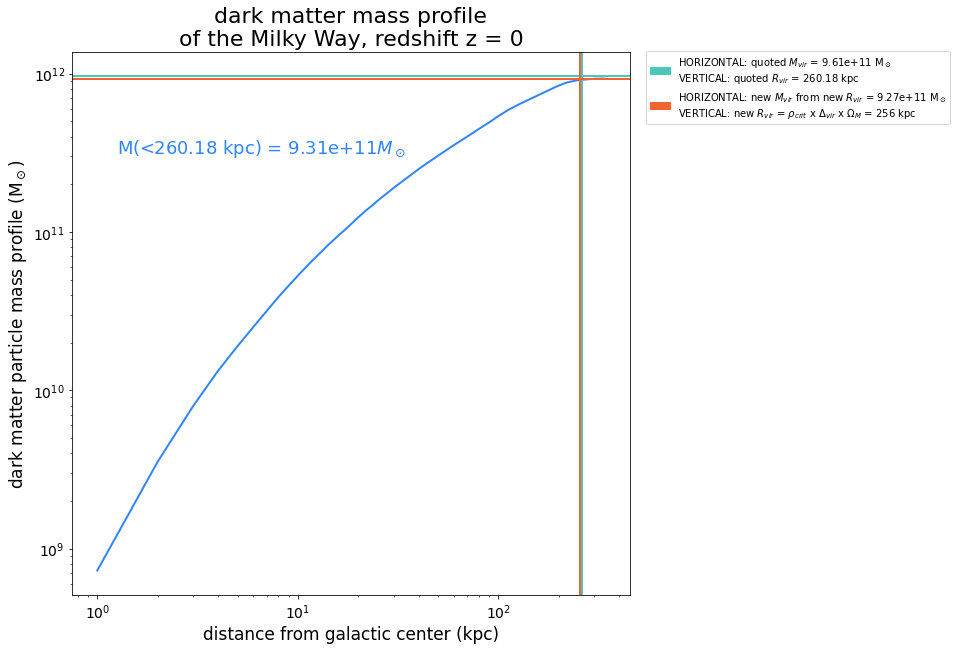

In [19]:
# virial mass mentioned by Ekta: 961482460000.0 M_Sun

TNG_Mvir = 961482460000.0
TNG_Rvir = 260.18414
TNG_mass_per_particle = 8857395.9256

halo6 = NFW_Z(TNG_Mvir, "TNG")

redshift_7 = MakeMassProfile(TNG_Mvir, "TNG")

redshift_7.final_plot(r_MilkyWay, rad_array_MilkyWay, TNG_Rvir, 0, TNG_Mvir, 256, TNG_mass_per_particle, "TNG")

Ekta will send a number to possibly fill the difference. Plot "mass profile + that_number"